$ \theta = \{\psi, \sigma, \tau\} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros 1 para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>
$\tau$: Parametros 2 para cada Modelo $\{\tau_1, \tau_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \times \tau \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x, \tau_x)= p_{\sigma_x,\tau_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ e $\tau_x$ <br>

$p_{\theta}(s_{t+1}|s_t, a_t) = \mu(s_{t+1}, s_t, a_t, \sigma_1, \tau_1) \; \times \; \beta(s_t)_1 + \mu(s_{t+1}, s_t, a_t, \sigma_2, \tau_2) \; \times \; \beta(s_t)_2 + ...$


$p_{\theta}(s_{t+1}|s_t, a_t) = \sum_{i=1}^k \mu(s_{t+1}, s_t, a_t, \sigma_i, \tau_i) \beta(s_t)_i \;\;\;\;\; for \;\; k = |\sigma_{\theta}|$  


$\mu: S \times S \times A \times \sigma_{\theta} \times \tau_{\theta} \mapsto [0,1]; \;\; \mu(s', s, a, \sigma, \tau) = pdf(s'_x, (s_x+(a_x \times \tau)), \sigma) \; \times \; pdf(s'_y, (s_y+ (a_y \times \tau)), \sigma)$

$\cal{L}[\xi | \theta] = \sum_{t=0}^{\mathrm{T}-1} log \; p_{\theta}(s_{t+1}|s_t, a_t)$

In [1]:
from environment import NormalMoveEnv
from experiment import Trajectory
from nn import BetaModel, Model, GeneralModel
from rl import Agent

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

<AxesSubplot: >

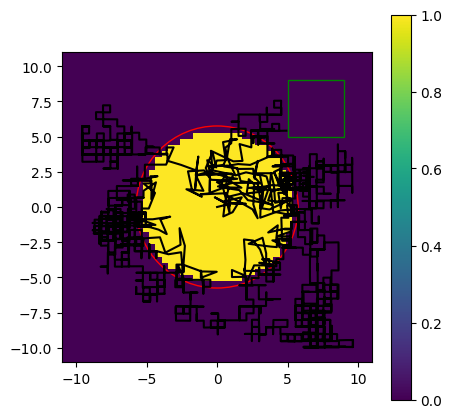

In [2]:
env = NormalMoveEnv()
t = Trajectory(env)
t.plot(env.plot())

In [3]:
m = GeneralModel(env, lr=1e-9, momentum=.9)
# ll = m.batch_train(t.run, 1000, log=True)
ll = m.batch_train(t.run, 1000)
print(ll[0], ll[-1])

v = m.model(torch.tensor([[0.,0.], [-9.,-9.]]).type(torch.DoubleTensor))
print(torch.exp(v[:,0]))
print(v[:,1])
# print(torch.exp(v))

4306.609877860043 4175.319608388885
tensor([0.8643, 0.8639], dtype=torch.float64, grad_fn=<ExpBackward0>)
tensor([-0.2821, -0.3680], dtype=torch.float64, grad_fn=<SelectBackward0>)


<AxesSubplot: >

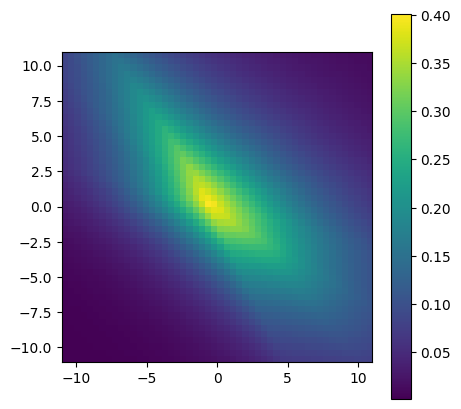

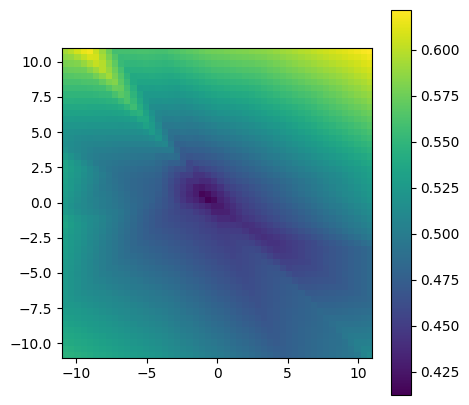

In [12]:
# m.batch_train(t.run, 1_000_000)
m.plot(param=0)
m.plot(param=1)

In [5]:
# import torch
# from torch.distributions import normal

# s = torch.tensor([0, 0])
# a = torch.tensor([0, 1])
# s_ = torch.tensor([0, 1])

# params = torch.tensor([.5, 0])

# -torch.sum(
#     normal.Normal(s[0] + a[0]*params[0], params[1]+1e-10).log_prob(s_[0])
#     +
#     normal.Normal(s[1] + a[1]*params[0], params[1]+1e-10).log_prob(s_[1])
# )

# Teste

In [72]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

import itertools
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib.patches import Circle, Rectangle

In [73]:

class ParModel(nn.Module):
    def __init__(self):
        super(ParModel, self).__init__()
        n_features = 1
        n_params = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden).double(),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden).double(),
            nn.ReLU(),
            nn.Linear(n_hidden, n_params).double(),
        )
        
    def forward(self, x):
        return self.model(x)

In [168]:
class GeneralModel:
    def __init__(self, model=None, lr=1e-4, momentum=.9):
        self.model = model or ParModel()
        self.lr = lr
        self.momentum = momentum
        self.optim = torch.optim.SGD(list(self.model.parameters()), lr=self.lr, momentum=self.momentum)

    def loss(self, params, s):
        return -torch.sum(normal.Normal(params[:,0], torch.exp(params[:,1])).log_prob(s[:]))
   
    def batch_train(self, historic_data, epochs=100):
        s = historic_data
        register = []
        
        self.model.train(True)
        for epoch in range(epochs):
            self.optim.zero_grad()
            outputs = self.model(s.reshape(-1,1))
            # outputs = self.model(s)
            ll = self.loss(outputs, s)
            ll.backward()
            self.optim.step() 
            register.append(ll.item())
        self.model.train(False)

        return register

In [179]:
size = 1000
p1 = np.zeros(shape=(size,)) + np.random.normal(0,10, size)
p2 = np.exp(np.zeros(shape=(size,)) + np.random.normal(0,1, size))
s = np.random.normal(p1, p2, size).astype(np.double)
# s__ = np.random.normal(s, 1, size).astype(np.float32)


m = GeneralModel(lr=1e-8, momentum=.9)
ll = m.batch_train(torch.from_numpy(s), 1000)
print(ll[0], ll[-1])

v1 = []
v2 = []
for i in range(size):
    l = m.model(torch.tensor([[s[i]]]).type(torch.DoubleTensor))
    v1.append((p1[i]-l[:,0].item())**2)
    v2.append((p2[i]-l[:,1].item())**2)

print(np.sum(np.array(v1))/size)
print(np.sum(np.array(v2))/size)

73140.45864795831 3324.7131172021172
96.31541756202309
5.1315896715641305


In [187]:
ll = m.batch_train(torch.from_numpy(s), 10000)
print(ll[0], ll[-1])

v1 = []
v2 = []
for i in range(size):
    l = m.model(torch.tensor([[s[i]]]).type(torch.DoubleTensor))
    v1.append((p1[i]-l[:,0].item())**2)
    v2.append((p2[i]-l[:,1].item())**2)

print(np.sum(np.array(v1))/size)
print(np.sum(np.array(v2))/size)

-1538.571184175953 -1350.7096030936946
5.348552854122698
20.629759368034946


In [198]:
# s = torch.tensor([ [0.  , 0.],[1.3 , 0. ],[1.8  , 3.8]])
# a = torch.tensor([ [1.  , 0.],[0.  , 1. ],[1.   , 0. ]])
# s_ = torch.tensor([[1.3 , 0.],[1.8 , 3.8],[12.5 , 0.9]])

# s = torch.tensor([ [0. , 0.],[1. , 0.],[1. , 5.]])
# a = torch.tensor([ [1. , 0.],[0. , 1.],[1. , 0.]])
# s_ = torch.tensor([[1. , 0.],[1. , 5.],[11 , 5.]])

# params1 = torch.tensor([1 , 5 , 10])
# params2 = torch.tensor([.5, 1 , 3])
# # params2 = torch.take(torch.tensor((.005,.3)), 1*(torch.sum(s**2, 1)**(1/2) < 5))

# diff = s_- (s + a*params1.reshape((-1,1)))
# dist = normal.Normal(0, params2)
# -torch.sum( dist.log_prob(diff[:,0]) + dist.log_prob(diff[:,1]) )

tensor(7.8440)